**PART 6 - DSIM project**

**Authors:** Francesca De Cola, Valentina Moretto, Valentina Zangirolami

In this notebook, we test different structure of ensemble model.

**Load packages**

In [ ]:
import numpy as np
import glob
from PIL import Image
import cv2
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2 as cv
import keras


from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.preprocessing import image

import tensorflow as tf
import pickle
import random 

Using TensorFlow backend.
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

**Seed for reproducibility**

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

**Load dataset of images**

(We create this npz file in 1_creation_dataset.ipynb)

In [ ]:
data=np.load("C:/Users/valen/Desktop/magistrale/DSIM/dataset_imgs.npz")
label=data['Y']
img=data['X']

**Preprocessing labels and images**

(Same at previous notebook, Fine_tuning_4 and CNN_5)

In [ ]:
le = LabelEncoder()
label=le.fit_transform(label)
img = img.astype('float32')
img = preprocess_input(img, version = 2)

**Train-Validation-Test partition**

We use the same partion of previous notebook, we set the same seed to obtain the same test set for compare results.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, label, test_size = .2, random_state = SEED, stratify = label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = SEED, stratify = y_train)
x_train.shape, x_val.shape, x_test.shape

((1452, 224, 224, 3), (363, 224, 224, 3), (454, 224, 224, 3))

We define *y_eff* to save test labels for classification_report (and confusion matrix). After, we complete the preprocessing phase for labels with to_categorical function.

In [ ]:
y_eff=y_test
y_train= to_categorical(y_train, num_classes=7)
y_val= to_categorical(y_val, num_classes=7)
y_test= to_categorical(y_test, num_classes=7)

**Ensemble Model**

Initially, we load four models:
* model_ft1 and model_ft2: refers to a model in which we apply fine tuning techniques. They represents the two best model of the scripts Fine_tuning_4.ipynb
* model_cnn1: refers to our CNN with the best cut of vggface (layer: add_12). It is the last model of the scripts CNN_5
* base_model: it is the pretrained neural network VGGFace. It is necessary for model_cnn1, because we use this to extract features of images before model_cnn1.

In [ ]:
model1=tf.keras.models.load_model('C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp4.best.hdf5')
model2=tf.keras.models.load_model('C:/Users/valen/Desktop/magistrale/DSIM/aml/weights-tmp3.best.hdf5')
model_cnn1=load_model('C:/Users/valen/Desktop/magistrale/DSIM/aml_cnn/cnn_best.h5')
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
#feature extraction
model = Model(inputs=base_model.input, outputs=base_model.get_layer('add_12').output)
extract_features = model.predict(x_test)
#prediction for each model
pred_cnn = model_cnn1.predict(extract_features)
pred1= model1.predict(x_test)
pred2= model2.predict(x_test)

We define two initial structure of ensamble:
1. First structure, save in final_pred_1, consider a mean with same weight for each prediction
2. In final_pred_2, We consider a weighted mean. We define weigths that take into account performance of each models. *model1* and *model_cnn* are the best models that have registred 91% of accuracy in the test phase, for this reasion we assign an 'high' value in ensemble. In different way, *model2* have 89% of accuracy on the test set.

In [ ]:
final_pred_1= 0.33*(pred1+pred2 + pred_cnn)
final_pred_2= 0.2*pred2 + 0.3*pred1 + 0.5*pred_cnn

**Classification report/Confusion Matrix Ensemble 1**

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        64
           1       0.91      0.83      0.87        60
           2       0.89      0.90      0.90        63
           3       1.00      0.98      0.99        64
           4       0.90      0.93      0.91        69
           5       0.97      0.81      0.88        73
           6       0.89      0.97      0.93        61

    accuracy                           0.91       454
   macro avg       0.91      0.91      0.91       454
weighted avg       0.91      0.91      0.91       454

Confusion matrix:
[[60  3  0  0  0  1  0]
 [10 50  0  0  0  0  0]
 [ 0  0 57  0  1  0  5]
 [ 0  1  0 63  0  0  0]
 [ 0  0  3  0 64  1  1]
 [ 3  1  4  0  5 59  1]
 [ 1  0  0  0  1  0 59]]


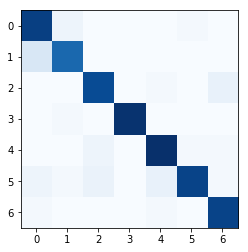

In [ ]:
y_pred_1=np.argmax(final_pred_1, axis=1)

print('Classification report:')
print(classification_report(y_eff, y_pred_1))

print('Confusion matrix:')
cm=confusion_matrix(y_eff, y_pred_1)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Performance are very confortable, Accuracy and other indicator are very high. We note, only, that classes 0,2 and 5 registered less performance than other classes. In fact, if we observe a confusion matrix we note that in corrispondence of these classes we have more 'false negative'.

**Classification report/Confusion Matrix Ensemble 2**

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        64
           1       0.90      0.87      0.88        60
           2       0.92      0.90      0.91        63
           3       1.00      0.98      0.99        64
           4       0.90      0.94      0.92        69
           5       0.95      0.84      0.89        73
           6       0.89      0.97      0.93        61

    accuracy                           0.91       454
   macro avg       0.92      0.92      0.91       454
weighted avg       0.92      0.91      0.91       454

Confusion matrix:
[[58  4  0  0  0  2  0]
 [ 8 52  0  0  0  0  0]
 [ 0  0 57  0  1  0  5]
 [ 0  1  0 63  0  0  0]
 [ 0  0  2  0 65  1  1]
 [ 2  1  3  0  5 61  1]
 [ 1  0  0  0  1  0 59]]


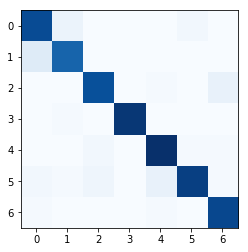

In [ ]:
y_pred_2=np.argmax(final_pred_2, axis=1)

print('Classification report:')
print(classification_report(y_eff, y_pred_2))

print('Confusion matrix:')
cm=confusion_matrix(y_eff, y_pred_2)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

The difference between the first ensemble model is really minimal. We obtain the same value of accuracy, but it is possible to notice that other metrics (recall, precision and f1-score) are more balanced. We think that this model is better than the first, it is possible to note that the problems highlighted above remain but seem to be less relevant.

**Classification report/Confusion Matrix Ensemble 3**

We define another structure of ensemble in which we give much more importance to *model1* and *model_cnn*.

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.91      0.87      0.89        60
           2       0.95      0.90      0.93        63
           3       1.00      0.98      0.99        64
           4       0.90      0.94      0.92        69
           5       0.94      0.86      0.90        73
           6       0.89      0.97      0.93        61

    accuracy                           0.92       454
   macro avg       0.92      0.92      0.92       454
weighted avg       0.92      0.92      0.92       454

Confusion matrix:
[[59  4  0  0  0  1  0]
 [ 7 52  0  0  0  1  0]
 [ 0  0 57  0  1  0  5]
 [ 0  1  0 63  0  0  0]
 [ 0  0  1  0 65  2  1]
 [ 2  0  2  0  5 63  1]
 [ 1  0  0  0  1  0 59]]


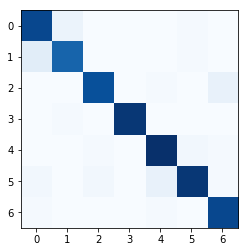

In [ ]:
final_pred_3 = 0.1*pred2 + 0.4*pred1 + 0.5*pred_cnn
y_pred_3=np.argmax(final_pred_3, axis=1)

print('Classification report:')
print(classification_report(y_eff, y_pred_3))

print('Confusion matrix:')
cm=confusion_matrix(y_eff, y_pred_3)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Accuracy value is more high. It is possible to observe that the problem is less relevant. We consider this model, our final model. In the following notebook, we consider this model for the demo.